# Basic Sequence to Sequence Modeling
seq2seq with RNNs is simple
```python
y, s = '<s>', encoder(x)
for _ in range(N):
    y, s = decoder(y, s)
```

### Imports

In [1]:
# Standard Lib
import os
import math
import random
from time import time
from pathlib import Path

# Visualization
import matplotlib.pyplot as plt

# Tokenization
import spacy 

# Loading Bar
from tqdm import tqdm

# Torch Imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Dataloader Custom Module
from sample_dataloader import get_dataloaders

### Data
Dataset from [here](https://pytorch.org/text/stable/_modules/torchtext/datasets/iwslt2016.html), key tokens:
```python
'<unk>' unkown token
'<pad>' padding token
'<bos>' beginning of sentence token
'<eos>' end of sentence token
```

In [ ]:
data_root = os.path.join(Path(os.getcwd()).parent.parent.parent, "Datasets/")
gpu = torch.device("cuda:0")

In [ ]:
!python -m spacy download en_core_web_sm

In [ ]:
!python -m spacy download de_core_news_sm

In [3]:
trainset, validset, testset, de_vocab, en_vocab = get_dataloaders(batch_size=128, device=gpu, data_root=data_root)

/opt/conda/lib/python3.8/site-packages/torchtext/data/field.py:150: UserWarning: Field class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)
/opt/conda/lib/python3.8/site-packages/torchtext/data/example.py:78: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.', UserWarning)
/opt/conda/lib/python3.8/site-packages/torchtext/data/iterator.py:48: UserWarning: BucketIterator class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information

In [4]:
# all these indices are the same for french and english
PAD_IDX = de_vocab['<pad>']
SOS_IDX = de_vocab['<sos>']
EOS_IDX = de_vocab['<eos>']

### Basic RNN Architecture
Lets first solve our machine translation problem with a simple RNN model

In [5]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()
        
        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout = dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src):
        
        embedded = self.dropout(self.embedding(src))
        outputs, (hidden, cell) = self.rnn(embedded)
        
        return hidden, cell

In [6]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()
        
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout = dropout)
        self.fc_out = nn.Linear(hid_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden, cell):
        input = input.unsqueeze(0)
        
        embedded = self.dropout(self.embedding(input))
        output, (hidden, cell) = self.rnn(embedded, (hidden, cell))
        prediction = self.fc_out(output.squeeze(0))
        
        return prediction, hidden, cell

In [7]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device, trg_vocab_size):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        self.trg_vocab_size = trg_vocab_size 
        
    def forward(self, src, trg, teacher_forcing_ratio=.5):
        batch_size = trg.shape[1]
        trg_len = trg.shape[0]
        
        outputs = torch.zeros(trg_len, batch_size, self.trg_vocab_size).to(self.device)
        
        hidden, cell = self.encoder(src)
        
        input = trg[0,:]
        
        for t in range(1, trg_len):
            output, hidden, cell = self.decoder(input, hidden, cell)
            
            outputs[t] = output
            
            # decide if we are going to use teacher forcing or not
            teacher_force = random.random() < teacher_forcing_ratio
            
            top1 = output.argmax(1) 
    
            input = trg[t] if teacher_force else top1
        
        return outputs

In [8]:
INPUT_DIM = len(de_vocab)
OUTPUT_DIM = len(en_vocab)
ENC_EMB_DIM = 128
DEC_EMB_DIM = 128
HID_DIM = 256
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)

model = Seq2Seq(enc, dec, gpu, OUTPUT_DIM).to(gpu)

In [9]:
# initialize model weights
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param.data, -0.08, 0.08)
        
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(7854, 128)
    (rnn): LSTM(128, 256, num_layers=2, dropout=0.5)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(5893, 128)
    (rnn): LSTM(128, 256, num_layers=2, dropout=0.5)
    (fc_out): Linear(in_features=256, out_features=5893, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [10]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 5,117,317 trainable parameters


### Training

In [11]:
def train(model, iterator, optimizer, criterion, clip=1, num_epochs=40):
    model.train()
    losses = []
    for _ in range(num_epochs):
        for i, batch in tqdm(enumerate(iterator), desc="iteration"):
            src = batch.src
            trg = batch.trg 
            
            optimizer.zero_grad()

            output = model(src, trg)

            output_dim = output.shape[-1]

            output = output[1:].view(-1, output_dim)
            trg = trg[1:].view(-1)
            
            loss = criterion(output, trg)
            losses.append(loss.item())
            loss.backward()

            # clip the gradients to prevent them from exploding (a common issue in RNNs)
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

            optimizer.step()
                    
    return model, losses

In [12]:
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)
model, losses = train(model, trainset, optimizer, criterion)

iteration: 0it [00:00, ?it/s]/opt/conda/lib/python3.8/site-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)
iteration: 227it [00:16, 13.69it/s]
iteration: 227it [00:16, 14.15it/s]
iteration: 227it [00:16, 14.05it/s]
iteration: 227it [00:16, 14.15it/s]
iteration: 227it [00:16, 14.06it/s]
iteration: 227it [00:15, 14.30it/s]
iteration: 227it [00:15, 14.38it/s]
iteration: 227it [00:16, 13.99it/s]
iteration: 227it [00:16, 14.02it/s]
iteration: 227it [00:16, 13.99it/s]
iteration: 227it [00:16, 14.17it/s]
iteration: 227it [00:16, 14.04it/s]
iteration: 227it [00:15, 14.26it/s]
iteration: 227it [00:16, 14.06it/s]
iteration: 227it [00:16, 14.05it/s]
iteration: 227it [00:15, 14.24

### Train Loss

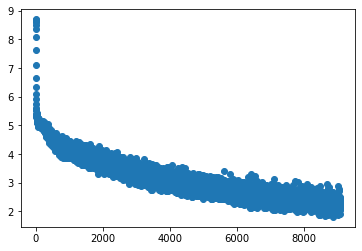

In [13]:
plt.scatter(x=list(range(len(losses))), y=losses)

### Sentence Samples

In [14]:
def tensor_2_str(tensor, vocab=de_vocab.itos):
    return " ".join([vocab[int(token)] for token in tensor if vocab[int(token)] not in ['<eos>', '<pad>', '.']])

In [18]:
with torch.no_grad():
    sample = next(iter(trainset))
    src, trg = sample.src, sample.trg
    output = model(src, trg)
    output_tensor = output.argmax(2)[:, 0]
    target_tensor = trg[:, 0]
    
    output = tensor_2_str(output_tensor, en_vocab.itos)
    expected = tensor_2_str(target_tensor, en_vocab.itos)
    N = max(len(output), len(expected)) + len("Expected: ")
    
    print("="*N)
    print("Output: {}".format(output).center(N))
    print("="*N)
    
    print("="*N)
    print("Expected: {}".format(expected).center(N))
    print("="*N)

  Output: <unk> a shirtless man man wearing sunglasses and a , walking down path , in a cloudy day  
Expected: <sos> a shirtless black man wearing sunglasses and jogging pants along a park path near a waterway
